# Data processing: sliding window

Reference:

Keipour, A., Mousaei, M., & Scherer, S. (2021). Alfa: A dataset for uav fault and anomaly detection. The International Journal of Robotics Research, 40(2-3), 515-520.

Dataset source: 

[ALFA: A Dataset for UAV Fault and Anomaly Detection](https://kilthub.cmu.edu/articles/dataset/ALFA_A_Dataset_for_UAV_Fault_and_Anomaly_Detection/12707963)

### Load the preprocessed data

In [5]:
import os
import dill
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sktime.datatypes._convert import convert_to
from sktime.datasets import write_dataframe_to_tsfile
from tsfresh.utilities.dataframe_functions import roll_time_series

warnings.filterwarnings('ignore')

In [3]:
df_file_name = "preprocessed_median-resampling_feature-selection.pkl"

with open(os.path.join("data", df_file_name), 'rb') as f:
    df_dict = dill.load(f)

### Calculate failure durations

In [17]:
def read_data(full_path):
    timestamp_column = "timestamp"
    df_tmp = pd.read_csv(full_path)
    df_tmp = df_tmp.rename(columns={"%time": timestamp_column})

    df_tmp[timestamp_column] = pd.to_datetime(df_tmp[timestamp_column], unit="ns")
    df_tmp.set_index(timestamp_column, inplace=True)
    return df_tmp


def extract_topic_name(flight_name, file_name):
    topic_name = file_name.split(flight_name)
    topic_name = topic_name[1]
    topic_name = topic_name[1:]
    topic_name = topic_name.split(".csv")
    topic_name = topic_name[0] 
    return topic_name

In [72]:
%%time

data_path = "data/processed/"
failure_column = "failure_status"

df_dict_with_failure = {}
failure_duration = []

for flight_name in list(df_dict.keys()):
    dfx = df_dict[flight_name]
    
    if "engine_failure" not in flight_name:
        failure_status = pd.DataFrame(data=[0] * len(dfx), 
                                      index=dfx.index, 
                                      columns=[failure_column]).head()
    else:
        status_file = flight_name + "-failure_status-engines.csv"
        failure_status = read_data(os.path.join(data_path, flight_name, status_file))
        failure_status = failure_status.resample("200ms").last()
        failure_status = failure_status.rename(columns={"field.data": failure_column})
    
    dfx = dfx.merge(failure_status, left_index=True, right_index=True, how="outer")
    dfx.iloc[0] = dfx.iloc[0].fillna(0)
    dfx = dfx.pad()
    dfx[failure_column] = dfx[failure_column].astype(int)
    
    if "engine_failure" in flight_name:
        idx = dfx[failure_column].ne(0).idxmax()
        failure_duration.append(len(dfx[dfx.index >= idx]))
    
    df_dict_with_failure[flight_name] = dfx
    
failure_duration = np.array(failure_duration)

CPU times: total: 188 ms
Wall time: 193 ms


In [73]:
print(f"Min flight duration:\t {failure_duration.min()}") 
print(f"Mean flight duration:\t {round(failure_duration.mean(), 2)}") 
print(f"Max flight duration:\t {failure_duration.max()}") 

Min flight duration:	 41
Mean flight duration:	 79.43
Max flight duration:	 118


In [74]:
failure_duration

array([ 81,  78,  80,  83,  97,  75,  74,  81,  96, 118, 113, 105,  47,
        63,  88,  66,  81,  61,  57,  72,  99,  41,  71])

In [75]:
np.sort(failure_duration)

array([ 41,  47,  57,  61,  63,  66,  71,  72,  74,  75,  78,  80,  81,
        81,  81,  83,  88,  96,  97,  99, 105, 113, 118])

In [ ]:
%%time

df_dict_rolled = {}
window_size = 40
steps = 5

for i, flight_name in enumerate(df_dict_with_failure.keys()):
    print("Flight:", flight_name)
    
    dfx = df_dict_with_failure[flight_name]
    
    if "no_failure" in flight_name:
        dfx_0 = dfx.copy()
        dfx_0["id"] = [i] * len(dfx_0)
        # print("dfx_0.columns:", dfx_0.columns)
        
        dfx_0_rolled = roll_time_series(
            df_or_dict=dfx_0,
            column_id="id",
            rolling_direction=steps,
            max_timeshift=(window_size-1),
            min_timeshift=(window_size-1),
            n_jobs=4
        )
        df_dict_rolled[f"{flight_name}_label_0"] = dfx_0_rolled
    
    elif "engine_failure" in flight_name:
        idx = dfx[failure_column].ne(0).idxmax()
        dfx_0 = dfx[dfx.index < idx]
        dfx_0["id"] = [i] * len(dfx_0)

        if len(dfx_0) > 0:
            dfx_0_rolled = roll_time_series(
                df_or_dict=dfx_0,
                column_id="id",
                rolling_direction=steps,
                max_timeshift=(window_size-1),
                min_timeshift=(window_size-1),
                n_jobs=4
            )
            df_dict_rolled[f"{flight_name}_label_0"] = dfx_0_rolled


        dfx_1 = dfx[dfx.index >= idx]
        dfx_1["id"] = [i] * len(dfx_1)

        if len(dfx_1) > 0:
            dfx_1_rolled = roll_time_series(
                df_or_dict=dfx_1,
                column_id="id",
                rolling_direction=steps,
                max_timeshift=(window_size-1),
                min_timeshift=(window_size-1),
                n_jobs=4
            )
            df_dict_rolled[f"{flight_name}_label_1"] = dfx_1_rolled

### Save the preprocessed data

In [102]:
df_file_name = "sliding_window-preprocessed_median-resampling_feature-selection.pkl"

with open(os.path.join("data", df_file_name), "wb") as f:
    dill.dump(df_dict_rolled, f)

### Split sliding windows into instances

In [ ]:
flight_name = 'carbonZ_2018-07-18-15-53-31_1_engine_failure_label_0' 
grouped = df_dict_rolled[flight_name].groupby('id')

cnt = 1
for name, group in grouped[0:1]:
    print(f"{cnt}. {flight_name}_instance_{name[0]}_{name[1]}")
    cnt += 1

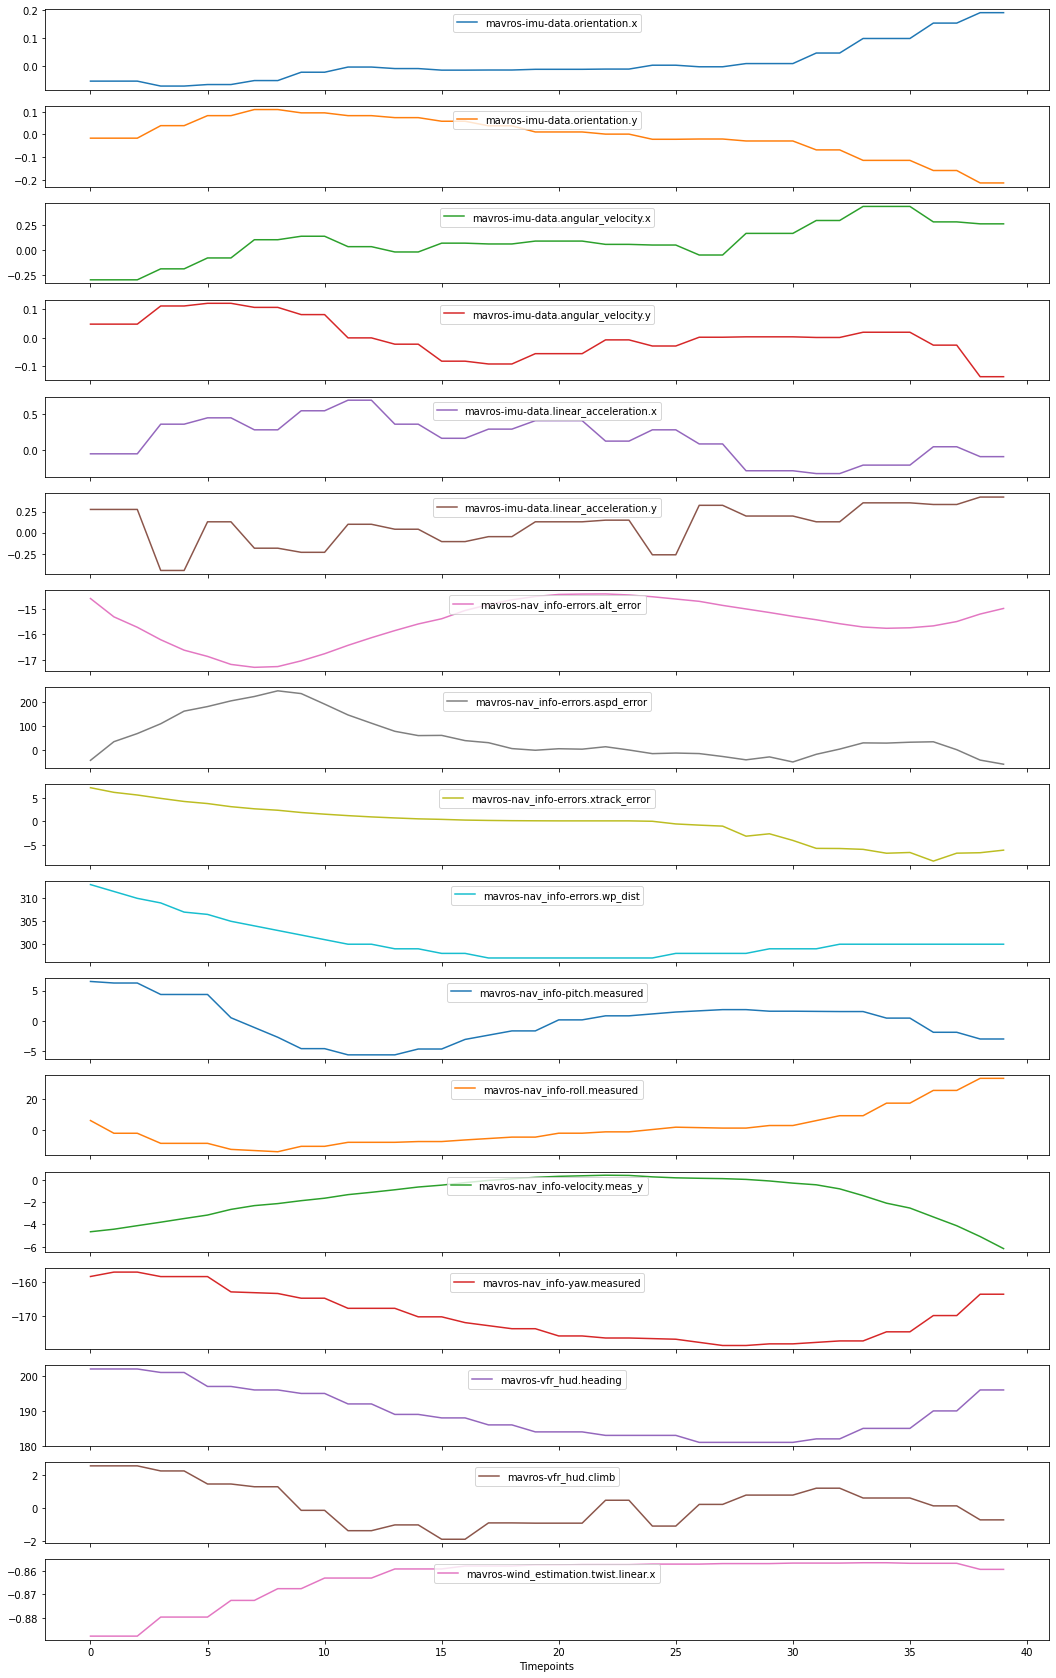

In [123]:
axes = group.drop(["failure_status", "id", "sort"], axis=1)\
    .reset_index(drop=True)\
    .plot(subplots=True, figsize=(18, 30))

for ax in axes:
    ax.legend(loc='upper center')

plt.xlabel("Timepoints")
plt.show()

### Nested DataFrame

In [ ]:
%%time

labels = []
instance = 0
df_nested = None
unused_columns = ["failure_status", "id", "sort"]


for i, flight_name in enumerate(df_dict_rolled.keys()):
    print(f"{i+1}. \t {flight_name}")

    grouped = df_dict_rolled[flight_name].groupby('id')

    for file_name, group in grouped:
        df_tmp = group.drop(unused_columns, axis=1).reset_index(drop=True)
        df_tmp["instances"] = instance
        df_tmp["timepoints"] = list(range(len(df_tmp)))
        
        if df_nested is None:
            df_nested = df_tmp
        else:
            df_nested = pd.concat([df_nested, df_tmp]) 
            df_nested = df_nested.reset_index(drop=True)
        
        labels.append(int(flight_name[-1]))
        
        instance += 1


df_nested = df_nested.set_index(["instances", "timepoints"])
labels = np.array(labels)

In [137]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([2596,  196], dtype=int64))

In [153]:
%%time

df_nested_univ = convert_to(df_nested, to_type="nested_univ")
df_nested_univ.head()

CPU times: total: 1min 35s
Wall time: 1min 41s


,mavros-imu-data.orientation.x,mavros-imu-data.orientation.y,mavros-imu-data.angular_velocity.x,mavros-imu-data.angular_velocity.y,mavros-imu-data.linear_acceleration.x,mavros-imu-data.linear_acceleration.y,mavros-nav_info-errors.alt_error,mavros-nav_info-errors.aspd_error,mavros-nav_info-errors.xtrack_error,mavros-nav_info-errors.wp_dist,mavros-nav_info-pitch.measured,mavros-nav_info-roll.measured,mavros-nav_info-velocity.meas_y,mavros-nav_info-yaw.measured,mavros-vfr_hud.heading,mavros-vfr_hud.climb,mavros-wind_estimation.twist.linear.x
instances,,,,,,,,,,,,,,,,,
0,0 0.192816 1 -0.115040 2 -0.115040 3...,0 0.035782 1 0.046311 2 0.046311 3...,0 2.048229 1 0.408364 2 0.408364 3...,0 -0.148680 1 -0.191198 2 -0.191198 3...,0 1.824037 1 0.068647 2 0.068647 3...,0 -0.323619 1 0.353039 2 0.353039 3...,0 -0.240000 1 -0.525000 2 -1.00500...,0 -239.042664 1 -254.399117 2 -172.95...,0 -32.799507 1 -74.159792 2 -120.08...,0 11.0 1 13.5 2 17.0 3 20.0 4 ...,0 2.718510 1 2.718510 2 6.68500...,0 -22.463430 1 -22.463430 2 12.61048...,0 19.294773 1 19.037812 2 18.55908...,0 82.601585 1 82.601585 2 78.13620...,0 82.0 1 78.0 2 78.0 3 76....,0 2.051253 1 -0.453115 2 -0.453115 3...,0 3.459940 1 3.459940 2 3.244974 3...
1,0 0.222649 1 0.222649 2 0.297463 3...,0 0.092829 1 0.092829 2 0.099476 3...,0 -0.777476 1 -0.777476 2 -0.232117 3...,0 -0.015224 1 -0.015224 2 -0.137537 3...,0 0.294200 1 0.294200 2 1.372931 3...,0 -0.186326 1 -0.186326 2 -0.402073 3...,0 -3.250000 1 -3.900000 2 -4.28000...,0 -145.747559 1 -106.689453 2 -45.53...,0 -131.370667 1 -134.718124 2 -137.21...,0 28.0 1 32.0 2 34.0 3 37.5 4 ...,0 7.995443 1 7.995443 2 7.02017...,0 -26.836985 1 -26.836985 2 -35.97161...,0 16.968301 1 16.740988 2 16.53771...,0 77.388718 1 77.388718 2 74.41744...,0 77.0 1 77.0 2 74.0 3 74....,0 3.855845 1 3.855845 2 -1.408057 3...,0 3.123330 1 3.003673 2 3.003673 3...
2,0 0.352863 1 0.374671 2 0.374671 3...,0 0.136949 1 0.217356 2 0.217356 3...,0 -0.283766 1 -0.105808 2 -0.105808 3...,0 -0.288865 1 -0.509014 2 -0.509014 3...,0 1.814230 1 3.579427 2 3.579427 3...,0 -0.274586 1 -0.029420 2 -0.029420 3...,0 -5.220000 1 -5.460000 2 -5.72000...,0 -82.268524 1 -152.542114 2 -196.84...,0 -147.634537 1 -150.525482 2 -153.19...,0 45.0 1 48.0 2 51.0 3 52.5 4 ...,0 7.090034 1 7.090034 2 8.32355...,0 -44.031116 1 -44.031116 2 -50.84606...,0 14.698441 1 13.373072 2 11.60352...,0 64.998405 1 64.998405 2 47.16870...,0 64.0 1 47.0 2 47.0 3 35....,0 3.776600 1 -2.749286 2 -2.749286 3...,0 2.774013 1 2.774013 2 2.573744 3...
3,0 0.328265 1 0.288278 2 0.288278 3...,0 0.322558 1 0.367327 2 0.367327 3...,0 -0.025609 1 0.256350 2 0.256350 3...,0 -0.600880 1 -0.679751 2 -0.679751 3...,0 3.098901 1 2.804702 2 2.804702 3...,0 -0.049033 1 -0.921825 2 -0.921825 3...,0 -6.750000 1 -7.150000 2 -7.60000...,0 -219.956589 1 -249.521637 2 -301.57...,0 -158.986893 1 -160.001175 2 -160.49...,0 58.0 1 60.0 2 62.0 3 63....,0 10.050631 1 10.050631 2 10.93986...,0 -54.170116 1 -54.170116 2 -54.94436...,0 5.599803 1 2.598276 2 -0.37968...,0 20.517736 1 20.517736 2 7.11999...,0 20.0 1 7.0 2 7.0 3 350....,0 2.000512 1 2.895363 2 2.895363 3...,0 2.474504 1 2.367711 2 2.367711 3...
4,0 0.162998 1 0.162998 2 0.033006 3...,0 0.416341 1 0.416341 2 0.385235 3...,0 0.559202 1 0.559202 2 0.723987 3...,0 -0.650299 1 -0.650299 2 -0.452044 3...,0 1.363124 1 1.363124 2 0.441299 3...,0 0.156906 1 0.156906 2 0.039227 3...,0 -9.429999 1 -10.190000 2 -11.12000...,0 -400.481415 1 -400.132935 2 -384.99...,0 -158.344055 1 -156.628021 2 -154.50...,0 65.0 1 65.0 2 65.0 3 65....,0 11.865973 1 11.865973 2 11.86597...,0 -52.172306 1 -52.172306 2 -52.17230...,0 -8.974410 1 -11.328129 2 -12.52377...,0 -23.271721 1 -23.271721 2 -23.27172...,0 336.0 1 336.0 2 319.0 3 319....,0 4.807531 1 4.807531 2 8.428056 3...,0 2.284087 1 2.270513 2 2.270513 3...


In [154]:
len(df_nested_univ), len(labels)

(2792, 2792)

### Save as .ts file

In [155]:
%%time

dataset_column = """
This dataset is a pre-processed version of the ALFA Dataset for UAV Fault and Anomaly Detection.
It contains 2596 instances with label 0 and 196 instances with label 1. 
Each serie has 40 timepoints of 8 seconds (5Hz).
"""

write_dataframe_to_tsfile(
    data=df_nested_univ,
    path="data/",
    problem_name="alfa-uav-fault-detection",
    class_label=np.unique(labels),
    class_value_list=labels,
    comment=dataset_column,
    equal_length=True,
    series_length=40,
)

CPU times: total: 17.4 s
Wall time: 17.9 s


### EDA on saved data

In [2]:
def tsplot(timepoints, 
           values, 
           n=20, 
           percentile_min=1, 
           percentile_max=99, 
           color='tab:blue', 
           plot_mean=True, 
           plot_median=False, 
           line_color='k', 
           **kwargs):
    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.percentile(values, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
    perc2 = np.percentile(values, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n
    
    if "ax" in kwargs:
        ax = kwargs.pop('ax')
    
    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        ax.fill_between(timepoints, p1, p2, alpha=alpha, color=color, edgecolor=None)


    if plot_mean:
        ax.plot(timepoints, np.mean(values, axis=0), color=line_color) #, label="mean")


    if plot_median:
        ax.plot(timepoints, np.median(values, axis=0), color=line_color) #, label="median")
    
    return ax

In [22]:
df_file_name = "sliding_window-preprocessed_median-resampling_feature-selection.pkl"

with open(os.path.join("data", df_file_name), 'rb') as f:
    dataset = dill.load(f)
    columns = dataset[list(dataset.keys())[0]].columns.difference(['failure_status', 'id', 'sort'])

In [50]:
from sktime.datasets import load_from_tsfile

X, y = load_from_tsfile("data/alfa-uav-fault-detection.ts", return_y=True, return_data_type="numpy3D")
X.shape, y.shape

((2792, 17, 40), (2792,))

In [32]:
# Scale the instances
X_scaled = []
X = np.swapaxes(X, 1, 2)

for i in range(X.shape[0]):
    scaler = StandardScaler()
    X_scaled.append(
        scaler.fit_transform(X[i])
    )

X_scaled = np.array(X_scaled)
X_scaled = np.swapaxes(X_scaled, 1, 2)
X_scaled.shape

(2792, 17, 40)

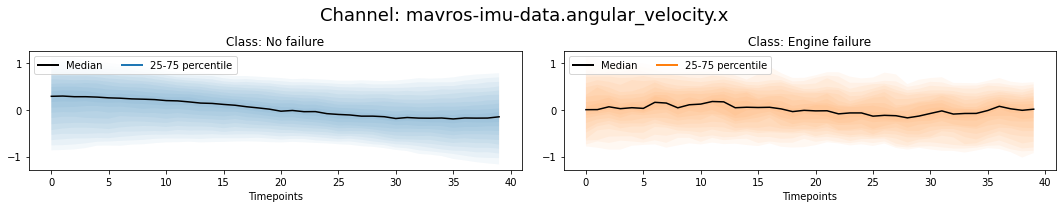

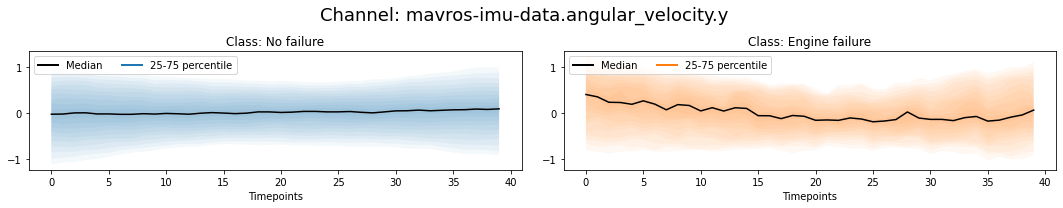

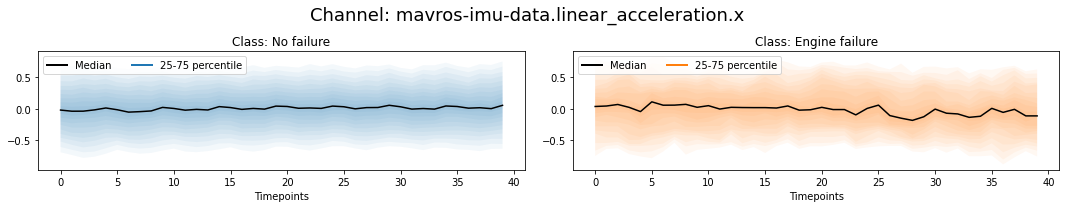

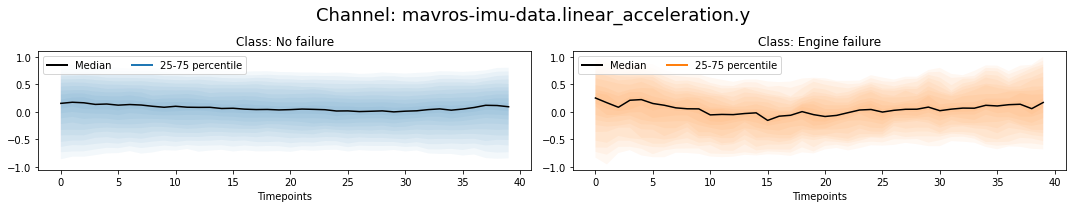

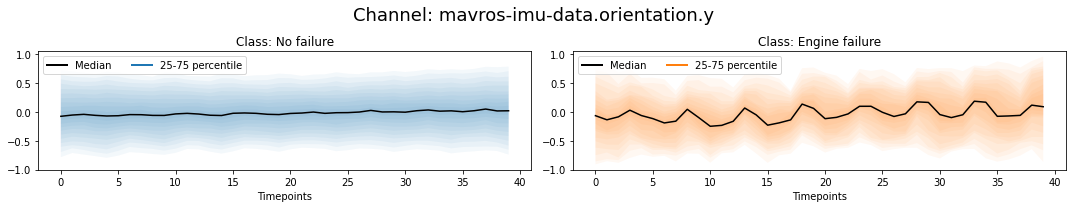

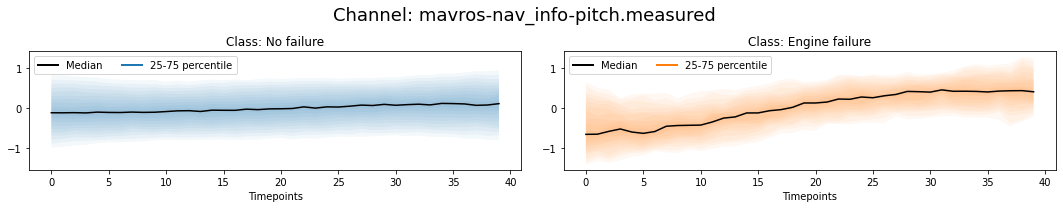

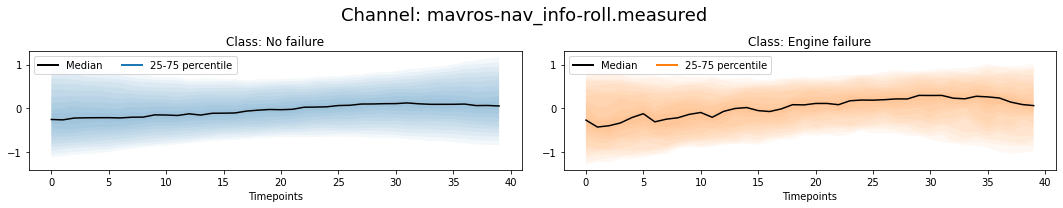

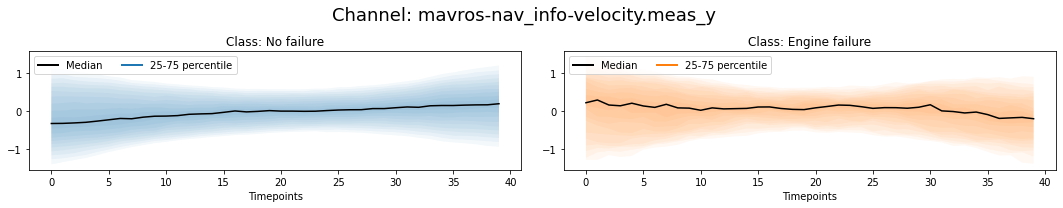

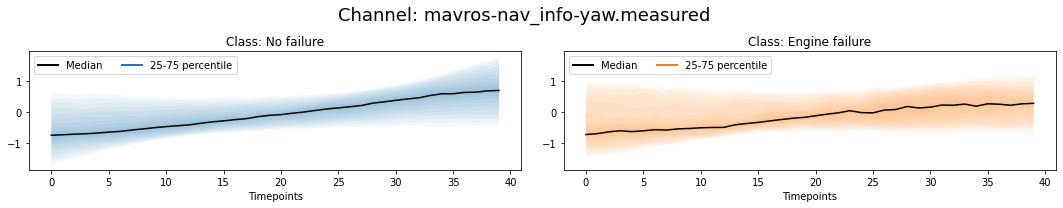

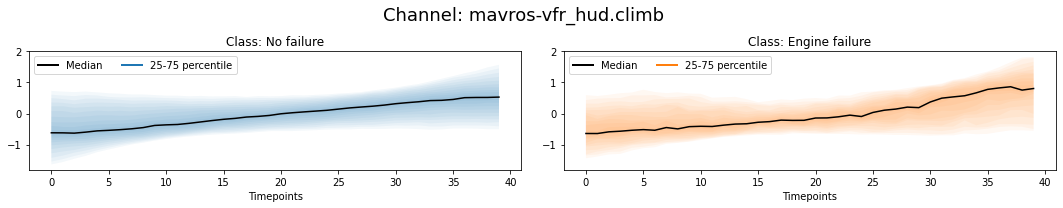

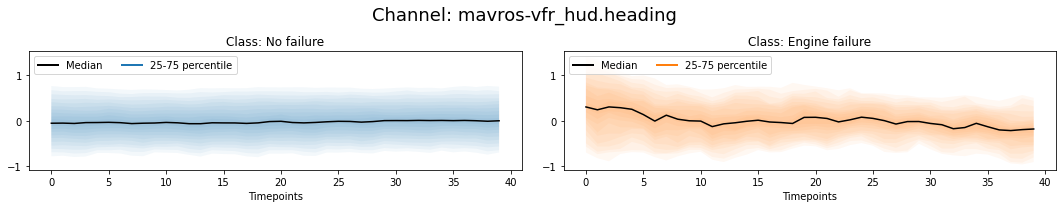

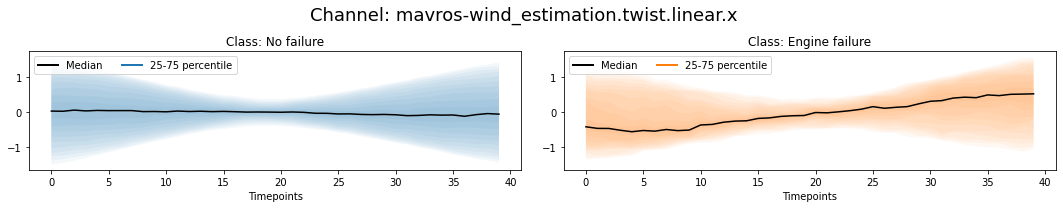

ignored_indices: [5, 6, 7]
CPU times: total: 2.78 s
Wall time: 2.78 s


In [55]:
%%time

label_dict = {
    "0": "No failure",
    "1": "Engine failure" 
}

ignored_indices = []

ignored_columns = [
    'mavros-imu-data.orientation.x', 
    'mavros-nav_info-errors.alt_error',
    'mavros-nav_info-errors.aspd_error',
    'mavros-nav_info-errors.wp_dist', 
    'mavros-nav_info-errors.xtrack_error',
]

for i, feature_col in zip(range(X_scaled.shape[1]), columns):
    if feature_col in ignored_columns:
        ignored_indices.append(i)
        continue
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 3))
    axs = axs.flatten()
    
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(f"Channel: {feature_col} ", fontsize=18, y=0.95)
    
    for k, label in enumerate(["0", "1"]):
        color = "tab:blue" if (label == "0") else "tab:orange"
        axs[k].set_xlabel("Timepoints")
        # axs[k].set_ylabel(feature_col)
    
        timepoints = list(range(0, X_scaled.shape[2], 1))
        values = X_scaled[np.where(y == label)[0], i, :]
        
        percentile_min=25
        percentile_max=75

        tsplot(timepoints=timepoints, 
               values=values, 
               n=10,
               plot_mean=False, 
               plot_median=True, 
               alpha=0.05, 
               color=color,
               percentile_min=25, 
               percentile_max=75,
               ax=axs[k])
        
        custom_legend_lines = [Line2D([0], [0], color="black", lw=2),
                        Line2D([0], [0], color=color, lw=2)]

        axs[k].legend(custom_legend_lines, 
                      ["Median", f"{percentile_min}-{percentile_max} percentile"], 
                      loc="upper left", 
                      ncol=2)
        
        axs[k].set_title(f"Class: {label_dict[label]}")
        axs[k].yaxis.set_tick_params(labelbottom=True)
        
    
    plt.tight_layout()
    plt.show()

print("ignored_indices:", ignored_indices)

In [58]:
X_scaled.shape

(2792, 15, 40)

In [59]:
np.delete(X_scaled, [], axis=1).shape

(2792, 12, 40)

In [60]:
columns = list(columns)
columns.remove('mavros-nav_info-errors.aspd_error')
columns.remove('mavros-nav_info-errors.wp_dist')
columns.remove('mavros-nav_info-errors.xtrack_error')

X_scaled = np.delete(X_scaled, [5, 6, 7], axis=1)

X_scaled.shape, len(columns)

((2792, 12, 40), 12)

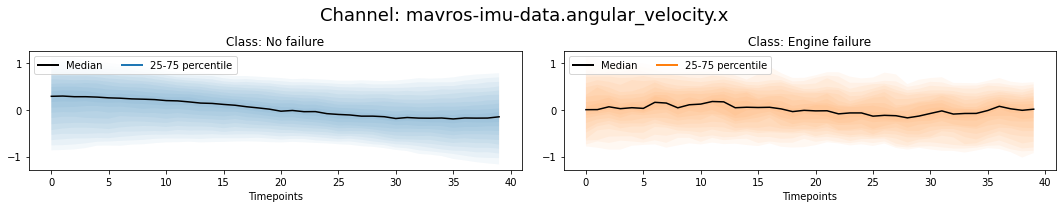

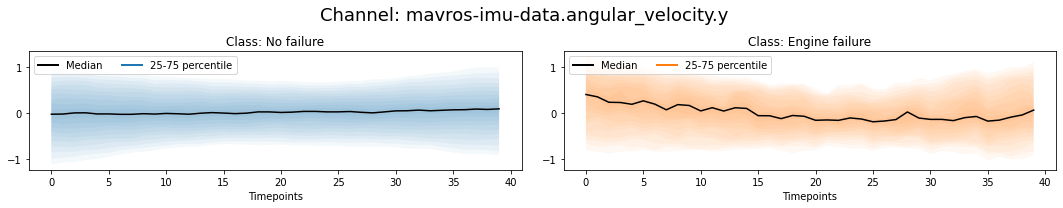

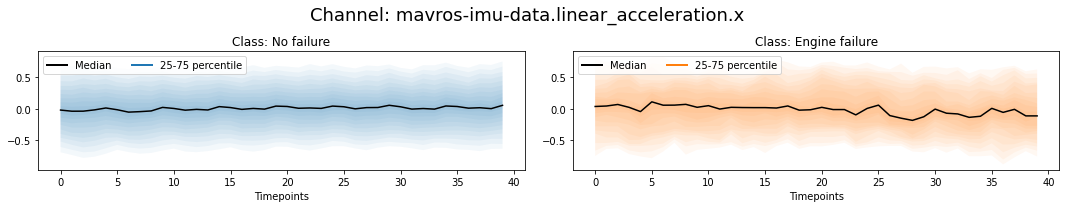

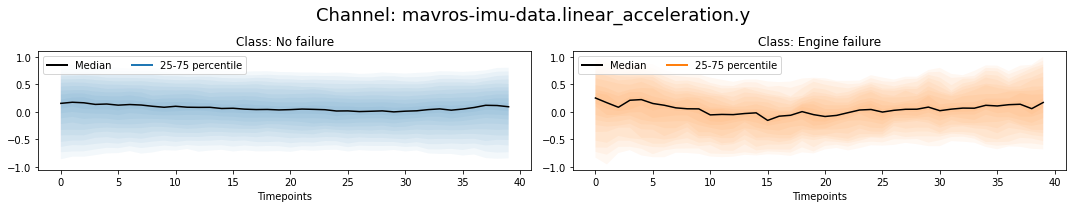

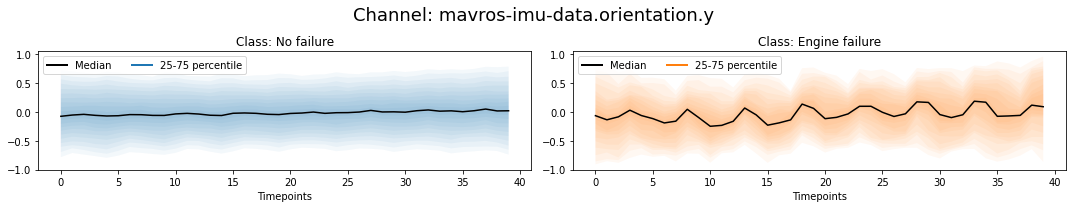

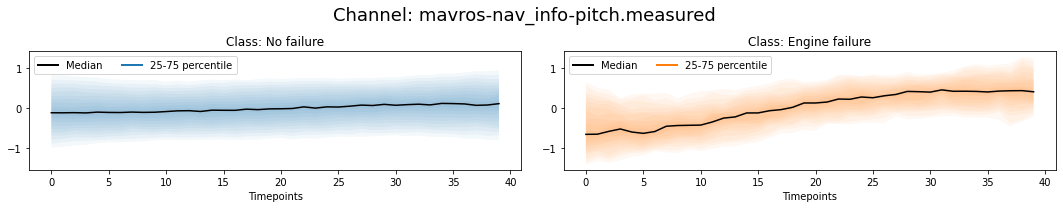

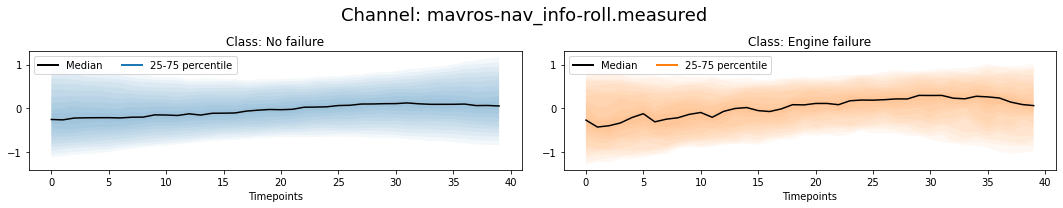

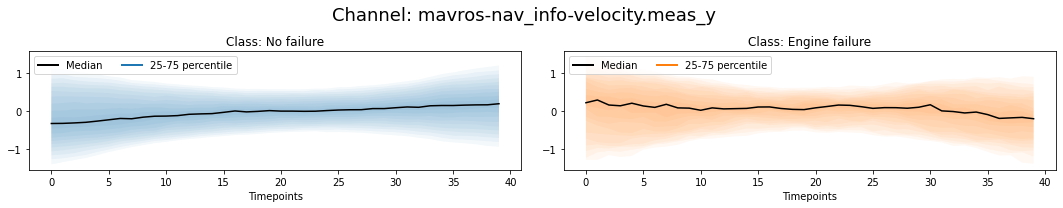

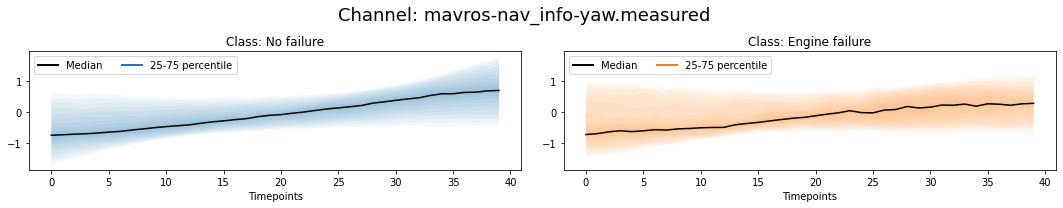

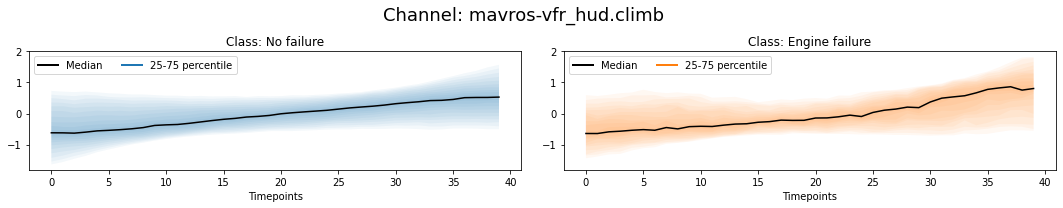

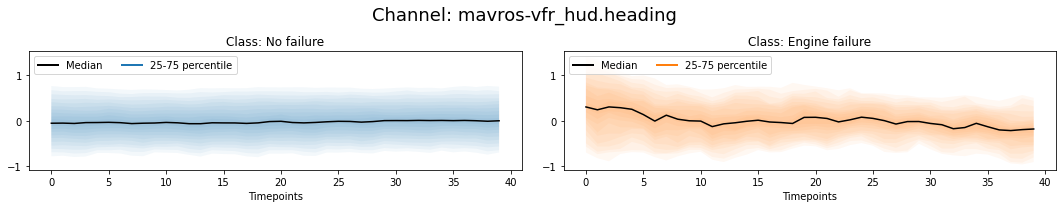

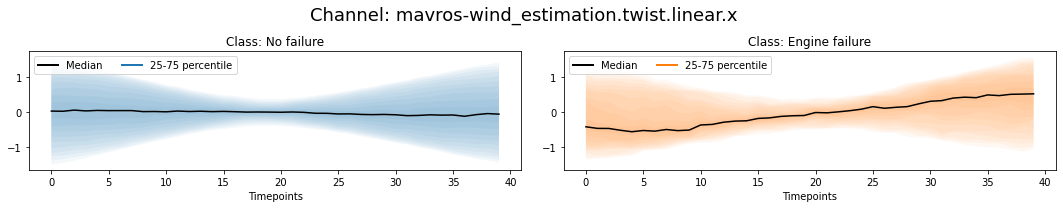

CPU times: total: 3.05 s
Wall time: 3.06 s


In [61]:
%%time

label_dict = {
    "0": "No failure",
    "1": "Engine failure" 
}

for i, feature_col in zip(range(X_scaled.shape[1]), columns):  
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 3))
    axs = axs.flatten()
    
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(f"Channel: {feature_col} ", fontsize=18, y=0.95)
    
    for k, label in enumerate(["0", "1"]):
        color = "tab:blue" if (label == "0") else "tab:orange"
        axs[k].set_xlabel("Timepoints")
        # axs[k].set_ylabel(feature_col)
    
        timepoints = list(range(0, X_scaled.shape[2], 1))
        values = X_scaled[np.where(y == label)[0], i, :]
        
        percentile_min=25
        percentile_max=75

        tsplot(timepoints=timepoints, 
               values=values, 
               n=10,
               plot_mean=False, 
               plot_median=True, 
               alpha=0.05, 
               color=color,
               percentile_min=25, 
               percentile_max=75,
               ax=axs[k])
        
        custom_legend_lines = [Line2D([0], [0], color="black", lw=2),
                        Line2D([0], [0], color=color, lw=2)]

        axs[k].legend(custom_legend_lines, 
                      ["Median", f"{percentile_min}-{percentile_max} percentile"], 
                      loc="upper left", 
                      ncol=2)
        
        axs[k].set_title(f"Class: {label_dict[label]}")
        axs[k].yaxis.set_tick_params(labelbottom=True)
        
    
    plt.tight_layout()
    plt.show()

In [64]:
%%time

dataset_comments = f"""
This dataset is a pre-processed version of the ALFA Dataset for UAV Fault and Anomaly Detection.
It contains 2596 instances with label 0 and 196 instances with label 1. 
Each serie has 40 timepoints of 8 seconds (5Hz). Column names: {columns}
"""

write_dataframe_to_tsfile(
    data=convert_to(X_scaled, to_type="nested_univ"),
    path="data/",
    problem_name="alfa-uav-fault-detection-scaled-12-channels",
    class_label=np.unique(y),
    class_value_list=y,
    comment=dataset_comments,
    equal_length=True,
    series_length=40,
)

CPU times: total: 3.61 s
Wall time: 3.6 s
